## Inference Pipeline

In [2]:
import torch
import numpy as np
from omegaconf import OmegaConf
from scripts.joint_regressor import JointRegressor
from scripts.checkpoint_utils import load_full_checkpoint
from scripts.dlrhand2_joint_datamodule import _sample_mesh_as_pc


def load_model(
    joint_ckpt: str,
    config_path: str,
    backbone_ckpt: str | None = None,
    device: str = "cuda:0"
) -> JointRegressor:
    """Instantiate JointRegressor, optionally load a JEPA backbone, then load trained joint-ckpt weights."""
    # Load training config
    cfg = OmegaConf.load(config_path)

    # Build model with training hyperparams
    model = JointRegressor(
        num_points           = cfg.data.num_points,
        tokenizer_groups     = cfg.model.tokenizer_groups,
        tokenizer_group_size = cfg.model.tokenizer_group_size,
        tokenizer_radius     = cfg.model.tokenizer_radius,
        transformations       = cfg.model.transformations,
        encoder_dim          = cfg.model.encoder_dim,
        encoder_depth        = cfg.model.encoder_depth,
        encoder_heads        = cfg.model.encoder_heads,
        encoder_dropout      = cfg.model.encoder_dropout,
        encoder_attn_dropout = cfg.model.encoder_attn_dropout,
        encoder_drop_path_rate=cfg.model.encoder_drop_path_rate,
        encoder_mlp_ratio    = cfg.model.encoder_mlp_ratio,
        pooling_type         = cfg.model.pooling_type,
        pooling_heads        = cfg.model.pooling_heads,
        pooling_dropout      = 0.1,
        head_hidden_dims     = cfg.model.head_hidden_dims,
        pose_dim             = 7,
        lr_backbone          = cfg.model.lr_backbone,
        lr_head              = cfg.model.lr_head,
        weight_decay         = cfg.model.weight_decay,
        encoder_unfreeze_epoch = cfg.model.encoder_unfreeze_epoch,
        num_pred              = cfg.model.num_pred,
        loss_type            = cfg.model.loss_type,
    )

    # Load backbone pretrain if provided
    if backbone_ckpt:
        load_full_checkpoint(model, backbone_ckpt)

    # Load full joint-regression checkpoint (overwrites head + backbone)
    checkpoint = torch.load(joint_ckpt, map_location=device)
    state = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state, strict=False)

    model.eval()
    model.freeze()
    model.to(device)
    return model


@torch.inference_mode()
def predict_joint_angles(
    model: JointRegressor,
    mesh_path: str,
    pose7d: list[float] | np.ndarray,
    num_points: int | None = None,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Given a mesh file and a 7D hand pose, returns the 12-D joint-angle prediction.
    """
    n_pts = num_points or model.hparams.num_points
    pc = _sample_mesh_as_pc(mesh_path, n=n_pts)

    pts = torch.from_numpy(pc).unsqueeze(0).to(device)
    pose = torch.as_tensor(pose7d, dtype=torch.float32).unsqueeze(0).to(device)

    if model.loss_type == "basic":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k_logit":
        pred_angles, pred_logit = model(pts, pose)  # (B, num_pred, 12), (B,num_pred), (B,num_pred)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit
    elif model.loss_type == "full":
        pred_angles, pred_logit, pred_score = model(pts, pose)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        pred_score = pred_score.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit, pred_score
    else:
        raise ValueError(f"Unknown loss type '{model.loss_type}'. Available types: "
                        f"basic, min_k, attention, min_k_logit, full")

# Example usage:
# model = load_model(
#     joint_ckpt="checkpoints/joint-final.ckpt",
#     config_path="configs/train_joint.yaml",
#     backbone_ckpt="checkpoints/pretrain-pointjepa.ckpt",  # optional
#     device="cuda:0"
# )
# angles = predict_joint_angles(model, mesh_path, hand_pose)
# print(angles)


Disabling PyTorch because PyTorch >= 2.1 is required but found 1.13.1+cu117
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Prediction Visualization

Using DIRECT mode, client ID: 0

 Closest to ground truth prediction: 
 [-0.003561  0.7666   -0.149    -0.2277    0.8784   -0.1902   -0.3599
  0.8555   -0.1823   -0.3147    0.5244   -0.2233  ]

 Inference time prediction: 
 [ 0.2603   0.726   -0.1312   0.06586  0.8076  -0.1476  -0.165    0.7715
 -0.1122  -0.3425   0.4739  -0.1633 ]
Grasp 0:
    palm  (xyz, qxqyqzqw) = [-0.046, -0.009, 0.27, -0.066, 0.976, 0.004, 0.208]
    joints (12 angles)  = [[0.260009765625, 0.72607421875, -0.1309814453125, 0.06597900390625, 0.80810546875, -0.14794921875, -0.1650390625, 0.77197265625, -0.11199951171875, -0.342041015625, 0.47412109375, -0.1629638671875], [0.406982421875, 1.34375, 1.572265625, 0.31103515625, 1.560546875, 1.5166015625, 0.040008544921875, 0.97998046875, -0.239990234375, -0.11798095703125, 0.591796875, -0.219970703125], [0.37890625, 1.5126953125, 1.7451171875, 0.260986328125, 0.875, -0.12298583984375, -0.134033203125, 0.8671875, -0.1719970703125, -0.256103515625, 0.55322265625, -0.18505

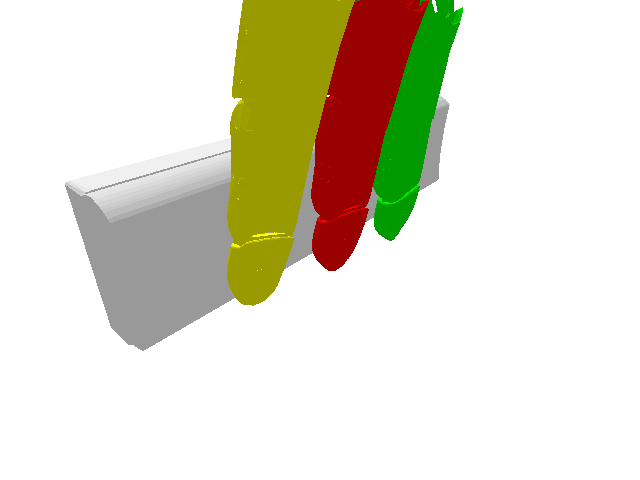


 Closest to ground truth prediction: 
 [-0.04016  0.7266  -0.1476  -0.249    0.84    -0.1786  -0.3684   0.8125
 -0.155   -0.3142   0.518   -0.2146 ]

 Inference time prediction: 
 [-0.04016  0.7266  -0.1476  -0.249    0.84    -0.1786  -0.3684   0.8125
 -0.155   -0.3142   0.518   -0.2146 ]
Grasp 1:
    palm  (xyz, qxqyqzqw) = [-0.042, 0.021, 0.277, -0.064, 0.979, -0.056, 0.186]
    joints (12 angles)  = [[0.217041015625, 0.69384765625, -0.1400146484375, 0.0189971923828125, 0.77978515625, -0.1510009765625, -0.2099609375, 0.73193359375, -0.09197998046875, -0.37109375, 0.464111328125, -0.1629638671875], [0.40087890625, 1.345703125, 1.5771484375, 0.301025390625, 1.5732421875, 1.521484375, 0.031005859375, 0.93115234375, -0.2259521484375, -0.1209716796875, 0.5859375, -0.218017578125], [0.35498046875, 1.52734375, 1.7568359375, 0.2259521484375, 0.83203125, -0.1190185546875, -0.1500244140625, 0.826171875, -0.14599609375, -0.2509765625, 0.5439453125, -0.176025390625], [0.2919921875, 0.3278808593

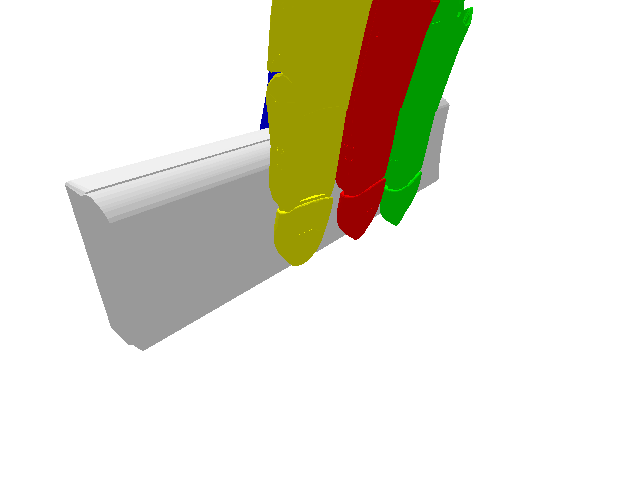


 Closest to ground truth prediction: 
 [ 0.3071    1.554     1.85     -0.03107   0.3394    0.1147    0.0957
  0.2024    0.2124   -0.1332   -0.1864    0.003506]

 Inference time prediction: 
 [ 0.4565   1.537    1.899    0.3806   1.534    1.897    0.1638   0.2401
  0.1392  -0.11316 -0.2101   0.05295]
Grasp 2:
    palm  (xyz, qxqyqzqw) = [-0.239, 0.04, 0.143, 0.53, 0.638, 0.172, 0.532]
    joints (12 angles)  = [[-0.0989990234375, 0.60400390625, -0.10797119140625, 0.03900146484375, 0.4140625, 0.0, 0.1099853515625, 0.444091796875, 0.1290283203125, -0.134033203125, -0.1639404296875, 0.058990478515625], [0.4560546875, 1.537109375, 1.8994140625, 0.3798828125, 1.5341796875, 1.8974609375, 0.1639404296875, 0.239990234375, 0.1390380859375, -0.11297607421875, -0.2099609375, 0.053009033203125], [0.306884765625, 1.5537109375, 1.849609375, -0.031005859375, 0.339111328125, 0.114990234375, 0.09600830078125, 0.2020263671875, 0.2120361328125, -0.133056640625, -0.18603515625, 0.004001617431640625], [0.0

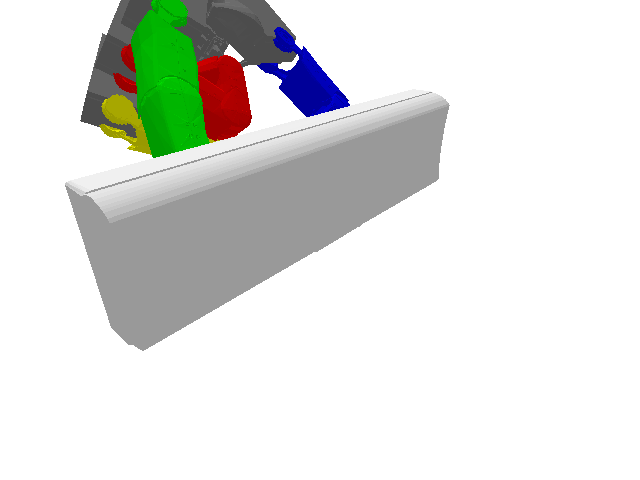


 Closest to ground truth prediction: 
 [-0.1295  0.4216 -0.1471 -0.3884  0.55   -0.2051 -0.501   0.5386 -0.2156
 -0.204   0.7886 -0.1832]

 Inference time prediction: 
 [-0.1295  0.4216 -0.1471 -0.3884  0.55   -0.2051 -0.501   0.5386 -0.2156
 -0.204   0.7886 -0.1832]
Grasp 3:
    palm  (xyz, qxqyqzqw) = [0.008, -0.006, 0.295, -0.053, 0.998, -0.013, 0.011]
    joints (12 angles)  = [[0.239013671875, 0.3349609375, -0.10601806640625, -0.072021484375, 0.4599609375, -0.1429443359375, -0.35498046875, 0.44189453125, -0.133056640625, -0.2529296875, 0.73388671875, -0.1490478515625], [0.427978515625, 1.3056640625, 1.5283203125, 0.31201171875, 1.37890625, 1.5986328125, -0.055999755859375, 0.63818359375, -0.248046875, -0.03399658203125, 0.85595703125, -0.2099609375], [0.387939453125, 1.46484375, 1.7568359375, 0.2320556640625, 0.5517578125, -0.1290283203125, -0.27197265625, 0.578125, -0.2359619140625, -0.2060546875, 0.7998046875, -0.1610107421875], [0.2939453125, -0.0279998779296875, 0.5859375, 0.

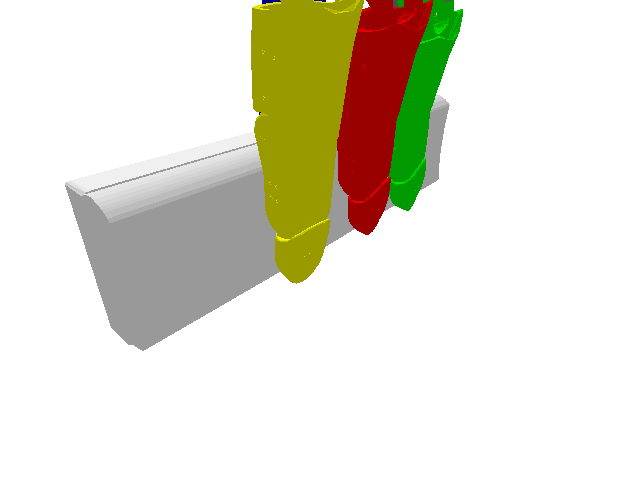


 Closest to ground truth prediction: 
 [ 0.2551   0.3596  -0.1154  -0.046    0.472   -0.1361  -0.332    0.4133
 -0.09705 -0.2379   0.784   -0.1526 ]

 Inference time prediction: 
 [-0.1005  0.4338 -0.1505 -0.3547  0.544  -0.1951 -0.4802  0.5327 -0.1965
 -0.2141  0.8247 -0.2112]
Grasp 4:
    palm  (xyz, qxqyqzqw) = [0.005, -0.008, 0.291, 0.996, 0.063, -0.034, 0.046]
    joints (12 angles)  = [[0.2548828125, 0.360107421875, -0.114990234375, -0.045989990234375, 0.471923828125, -0.135986328125, -0.33203125, 0.4130859375, -0.09698486328125, -0.238037109375, 0.7841796875, -0.1529541015625], [0.426025390625, 1.3154296875, 1.541015625, 0.31103515625, 1.3916015625, 1.4609375, -0.04901123046875, 0.6259765625, -0.2349853515625, -0.04400634765625, 0.89013671875, -0.22802734375], [0.384033203125, 1.439453125, 1.654296875, 0.2320556640625, 0.5341796875, -0.09600830078125, -0.257080078125, 0.55517578125, -0.2020263671875, -0.2120361328125, 0.837890625, -0.177001953125], [0.2958984375, 0.026000976562

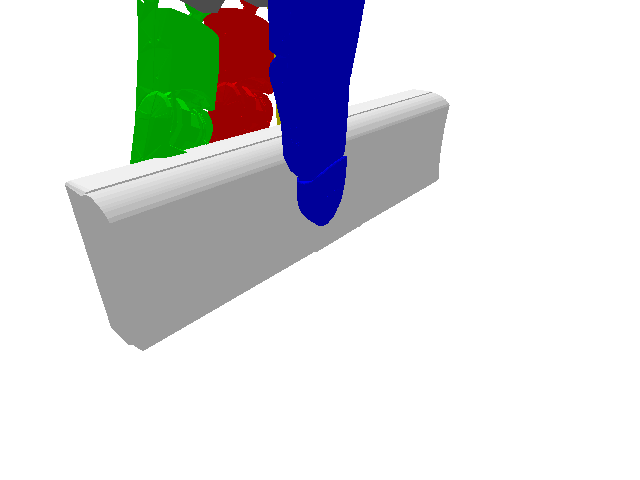


 Closest to ground truth prediction: 
 [ 0.4697   1.475    1.802    0.3906   1.352    1.785    0.1003   0.01098
  0.1805  -0.04837 -0.04733  0.1259 ]

 Inference time prediction: 
 [ 0.3748    1.469     1.756     0.07477   0.1034    0.1854    0.004032
 -0.00958   0.2042   -0.1298   -0.0348    0.08453 ]
Grasp 5:
    palm  (xyz, qxqyqzqw) = [-0.044, -0.007, 0.29, 0.596, 0.794, 0.004, 0.118]
    joints (12 angles)  = [[0.040008544921875, 0.325927734375, -0.01399993896484375, 0.037994384765625, 0.1949462890625, 0.06201171875, -0.00800323486328125, 0.18994140625, 0.14697265625, -0.08001708984375, -0.0010004043579101562, 0.1199951171875], [0.469970703125, 1.474609375, 1.8017578125, 0.389892578125, 1.3515625, 1.78515625, 0.0999755859375, 0.0110015869140625, 0.1800537109375, -0.048004150390625, -0.0469970703125, 0.1259765625], [0.375, 1.46875, 1.755859375, 0.07501220703125, 0.10302734375, 0.18505859375, 0.004001617431640625, -0.01000213623046875, 0.2039794921875, -0.1300048828125, -0.03500366

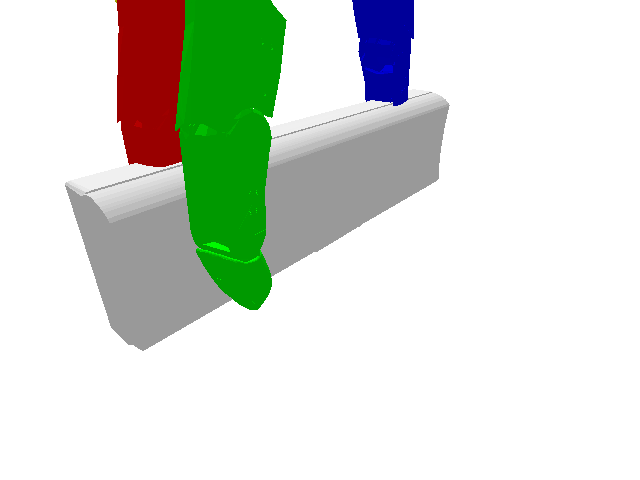


 Closest to ground truth prediction: 
 [-0.0807  0.6255 -0.1821 -0.3198  0.7446 -0.225  -0.4404  0.724  -0.2124
 -0.263   0.6353 -0.1882]

 Inference time prediction: 
 [-0.0807  0.6255 -0.1821 -0.3198  0.7446 -0.225  -0.4404  0.724  -0.2124
 -0.263   0.6353 -0.1882]
Grasp 6:
    palm  (xyz, qxqyqzqw) = [0.017, 0.034, 0.285, 0.989, 0.038, -0.116, 0.078]
    joints (12 angles)  = [[0.238037109375, 0.55419921875, -0.1529541015625, -0.0269927978515625, 0.6640625, -0.1739501953125, -0.297119140625, 0.61279296875, -0.1199951171875, -0.300048828125, 0.591796875, -0.1280517578125], [0.407958984375, 1.326171875, 1.552734375, 0.297119140625, 1.4814453125, 1.431640625, -0.02099609375, 0.833984375, -0.26904296875, -0.0789794921875, 0.7060546875, -0.2020263671875], [0.361083984375, 1.4755859375, 1.6650390625, 0.22705078125, 0.73486328125, -0.1429443359375, -0.218017578125, 0.744140625, -0.2060546875, -0.22998046875, 0.65576171875, -0.14501953125], [0.291015625, 0.2060546875, 0.51123046875, 0.0930

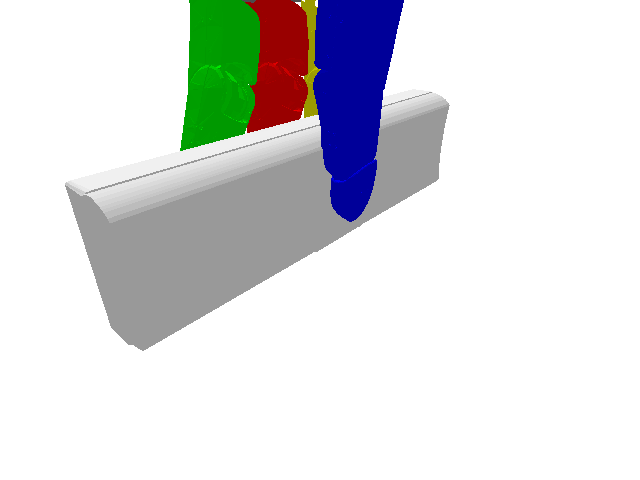


 Closest to ground truth prediction: 
 [-0.1098  0.5728 -0.183  -0.353   0.6914 -0.2251 -0.4666  0.6763 -0.2129
 -0.2354  0.6973 -0.1804]

 Inference time prediction: 
 [-0.1098  0.5728 -0.183  -0.353   0.6914 -0.2251 -0.4666  0.6763 -0.2129
 -0.2354  0.6973 -0.1804]
Grasp 7:
    palm  (xyz, qxqyqzqw) = [0.003, 0.047, 0.286, 0.992, 0.042, -0.078, 0.089]
    joints (12 angles)  = [[0.22705078125, 0.491943359375, -0.14599609375, -0.052001953125, 0.60693359375, -0.1700439453125, -0.320068359375, 0.55810546875, -0.11700439453125, -0.260986328125, 0.65283203125, -0.11297607421875], [0.4140625, 1.32421875, 1.552734375, 0.297119140625, 1.443359375, 1.4462890625, -0.0419921875, 0.7822265625, -0.26708984375, -0.061004638671875, 0.76220703125, -0.1949462890625], [0.35888671875, 1.4609375, 1.658203125, 0.2120361328125, 0.68603515625, -0.1419677734375, -0.2459716796875, 0.7001953125, -0.2139892578125, -0.217041015625, 0.712890625, -0.136962890625], [0.277099609375, 0.1500244140625, 0.51123046875,

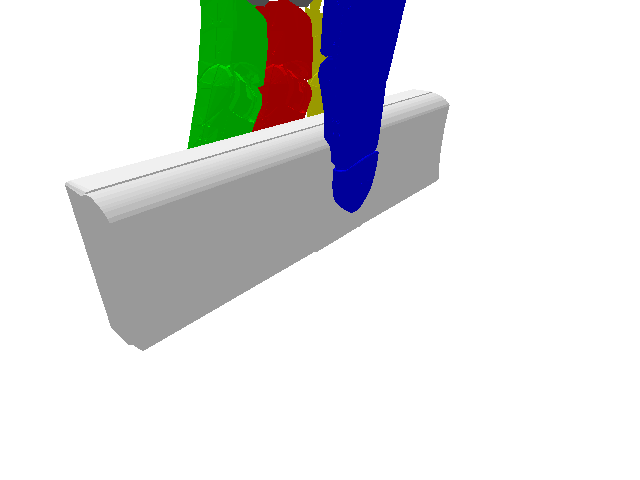


 Closest to ground truth prediction: 
 [-0.1024  0.6553 -0.2085 -0.3208  0.7515 -0.2345 -0.4194  0.7417 -0.2109
 -0.2235  0.607  -0.1865]

 Inference time prediction: 
 [-0.1024  0.6553 -0.2085 -0.3208  0.7515 -0.2345 -0.4194  0.7417 -0.2109
 -0.2235  0.607  -0.1865]
Grasp 8:
    palm  (xyz, qxqyqzqw) = [0.011, 0.084, 0.281, 0.977, 0.034, -0.114, 0.179]
    joints (12 angles)  = [[0.199951171875, 0.587890625, -0.177001953125, -0.0240020751953125, 0.6689453125, -0.18994140625, -0.2469482421875, 0.64794921875, -0.137939453125, -0.23095703125, 0.56201171875, -0.0999755859375], [0.4169921875, 1.3505859375, 1.5947265625, 0.303955078125, 1.474609375, 1.4736328125, -0.016998291015625, 0.84912109375, -0.284912109375, -0.07000732421875, 0.65576171875, -0.18603515625], [0.35205078125, 1.46875, 1.6611328125, 0.1910400390625, 0.76513671875, -0.1669921875, -0.2010498046875, 0.76220703125, -0.22802734375, -0.2099609375, 0.615234375, -0.136962890625], [0.27099609375, 0.261962890625, 0.47802734375, 0

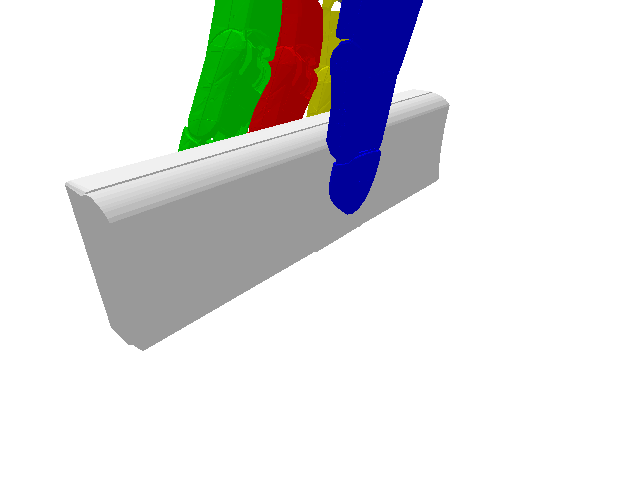


 Closest to ground truth prediction: 
 [-0.02226  0.7793  -0.1786  -0.2477   0.9023  -0.2206  -0.3794   0.869
 -0.2014  -0.332    0.4714  -0.1956 ]

 Inference time prediction: 
 [ 0.25     0.7285  -0.1649   0.02351  0.8286  -0.1805  -0.239    0.7705
 -0.1173  -0.3923   0.4275  -0.1451 ]
Grasp 9:
    palm  (xyz, qxqyqzqw) = [0.034, 0.018, 0.268, 0.977, 0.076, -0.191, 0.047]
    joints (12 angles)  = [[0.25, 0.72802734375, -0.1650390625, 0.0240020751953125, 0.828125, -0.1800537109375, -0.239013671875, 0.77001953125, -0.11700439453125, -0.39208984375, 0.427978515625, -0.14501953125], [0.39306640625, 1.3349609375, 1.556640625, 0.2919921875, 1.5791015625, 1.408203125, 0.0260009765625, 0.994140625, -0.26708984375, -0.1240234375, 0.5517578125, -0.2049560546875], [0.35595703125, 1.5166015625, 1.689453125, 0.25, 0.8837890625, -0.14697265625, -0.155029296875, 0.8818359375, -0.176025390625, -0.259033203125, 0.5048828125, -0.1510009765625], [0.31201171875, 0.365966796875, 0.51806640625, 0.133056

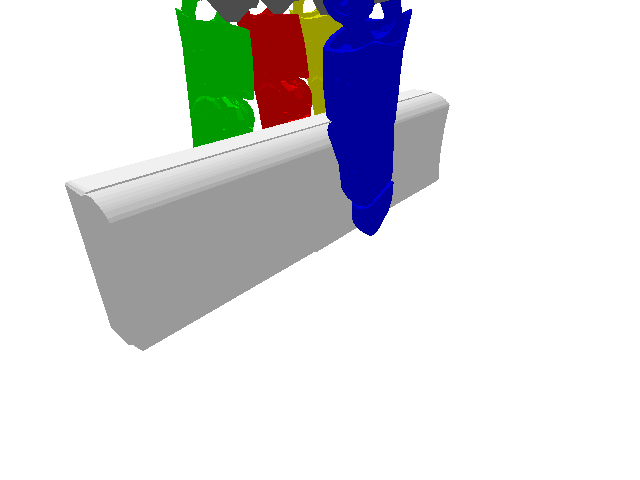

In [3]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Define your real data folder here ──
# not in the split_50, split_10
root = Path("../data/studentGrasping/student_grasps_v1/03211117/2f12da0c7460b22cd3ab2bc0f53ca878/3")

# not in the split_25, split_10
# root = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
# root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f = root / "mesh.obj"
recording = root / "recording.npz"

assert mesh_f.exists(), f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
print("Using DIRECT mode, client ID:", cid)

p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load your hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),  # update if your urdf is elsewhere
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load object mesh once ──
v = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
c = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
p.createMultiBody(
    baseVisualShapeIndex=v,
    baseCollisionShapeIndex=c,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    physicsClientId=cid,
)

# ── 5) Prepare model & data ──
model = load_model(
    joint_ckpt="../configs/checkpoints/epoch=49-step=82600.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

poses7d = grasps[:10, :7]             # hand poses
angles12 = grasps[:10, 7:19]          # joint angles - ground truth, just for comparison
scores_n = scores[:10]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop ──
for i, pose7d in enumerate(poses7d):
    if model.loss_type == "basic":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits, scores = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)

    distances = np.linalg.norm(angles - angles12[i], axis=1)  # shape: (K,)
    best_k = np.argmin(distances)
    best_prediction = angles[best_k] 
    print("\n Closest to ground truth prediction: \n",best_prediction)

    max_logit = np.argmax(logits)
    inference_prediction = angles[max_logit]
    print("\n Inference time prediction: \n", inference_prediction)

    # reset pose & joints
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    for a, j in zip(inference_prediction, [1,2,3,7,8,9,13,14,15,19,20,21]):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in {3,9,15,21}:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # snapshot
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.3,
        yaw=45, pitch=-30, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    w, h, rgba, _, _ = p.getCameraImage(640, 480,
                                        viewMatrix=view,
                                        projectionMatrix=proj,
                                        physicsClientId=cid)
    img = Image.fromarray(rgba[:, :, :3])

    print(f"Grasp {i}:")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)
    time.sleep(0.5)

p.disconnect(physicsClientId=cid)


### Ground Truth Prediction Visualization

Grasp 0: score = 12.953
    palm  (xyz, qxqyqzqw) = [-0.046, -0.009, 0.27, -0.066, 0.976, 0.004, 0.208]
    joints (12 angles)  = [0.029, 0.761, -0.095, -0.151, 0.891, -0.163, -0.396, 0.801, -0.115, -0.309, 0.471, -0.163]


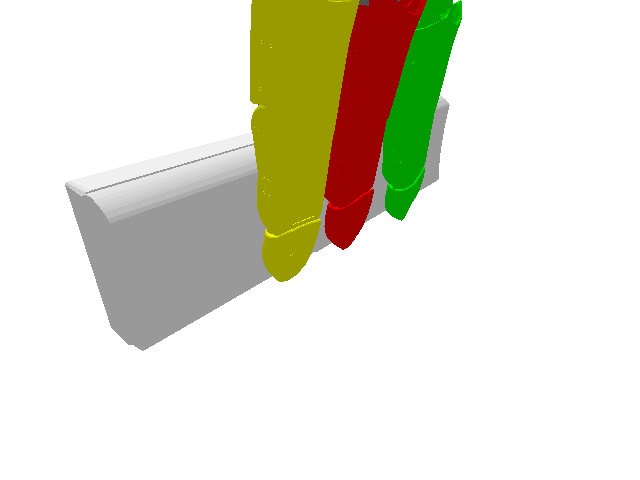

Grasp 1: score = 11.055
    palm  (xyz, qxqyqzqw) = [-0.042, 0.021, 0.277, -0.064, 0.979, -0.056, 0.186]
    joints (12 angles)  = [0.066, 0.741, -0.138, -0.138, 0.831, -0.137, -0.49, 0.791, -0.159, -0.269, 0.501, -0.157]


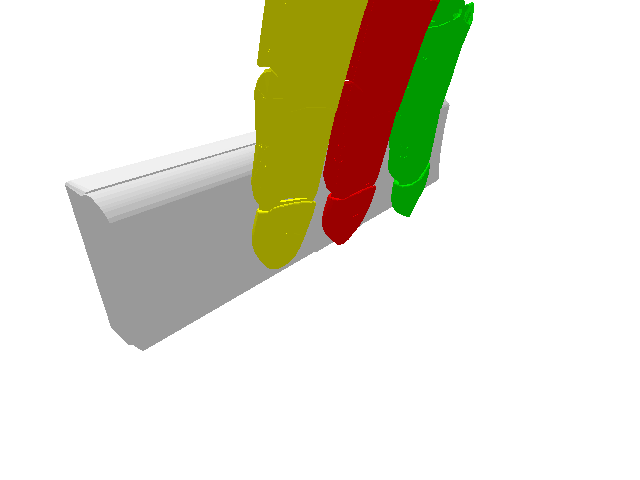

Grasp 2: score = -0.291
    palm  (xyz, qxqyqzqw) = [-0.239, 0.04, 0.143, 0.53, 0.638, 0.172, 0.532]
    joints (12 angles)  = [0.21, 1.501, 1.825, -0.121, -0.069, -0.139, -0.212, 0.031, 0.287, -0.317, 1.501, 1.825]


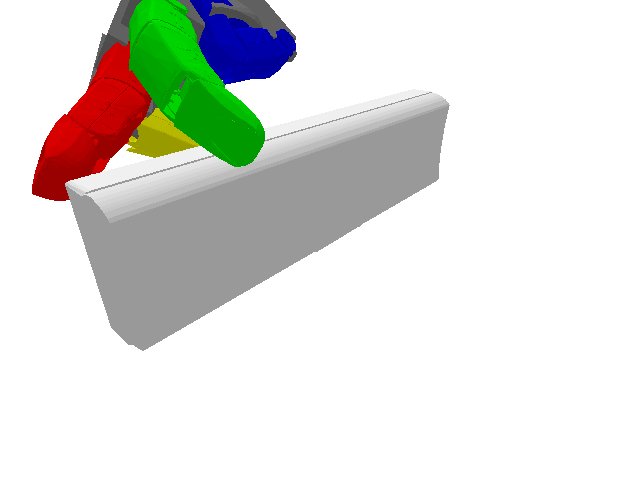

Grasp 3: score = 10.136
    palm  (xyz, qxqyqzqw) = [0.008, -0.006, 0.295, -0.053, 0.998, -0.013, 0.011]
    joints (12 angles)  = [0.01, 0.431, -0.124, -0.216, 0.521, -0.152, -0.518, 0.471, -0.154, -0.106, 0.741, -0.099]


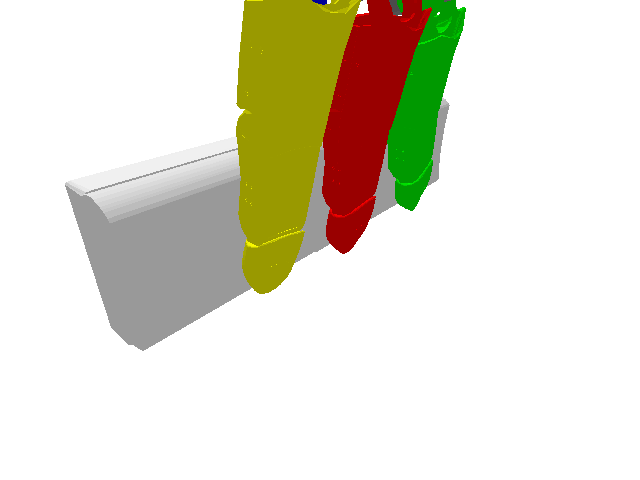

Grasp 4: score = 9.215
    palm  (xyz, qxqyqzqw) = [0.005, -0.008, 0.291, 0.996, 0.063, -0.034, 0.046]
    joints (12 angles)  = [0.496, 0.401, -0.173, 0.283, 0.491, -0.095, -0.428, 0.431, -0.083, -0.351, 0.701, -0.063]


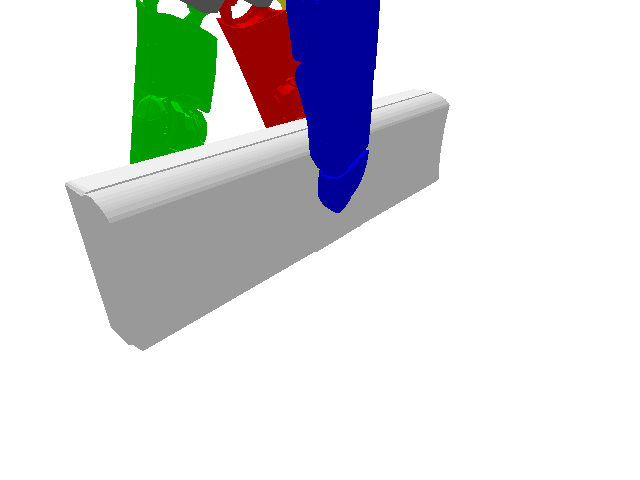

Grasp 5: score = -0.000
    palm  (xyz, qxqyqzqw) = [-0.044, -0.007, 0.29, 0.596, 0.794, 0.004, 0.118]
    joints (12 angles)  = [0.494, 1.501, 1.825, 0.452, 1.501, 1.825, -0.3, 0.841, 0.288, -0.038, -0.349, -0.165]


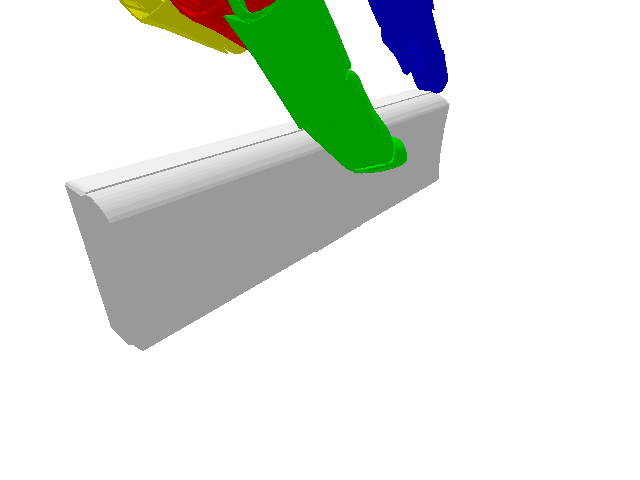

Grasp 6: score = 11.954
    palm  (xyz, qxqyqzqw) = [0.017, 0.034, 0.285, 0.989, 0.038, -0.116, 0.078]
    joints (12 angles)  = [0.049, 0.651, -0.125, -0.152, 0.761, -0.169, -0.318, 0.741, -0.166, -0.3, 0.561, -0.117]


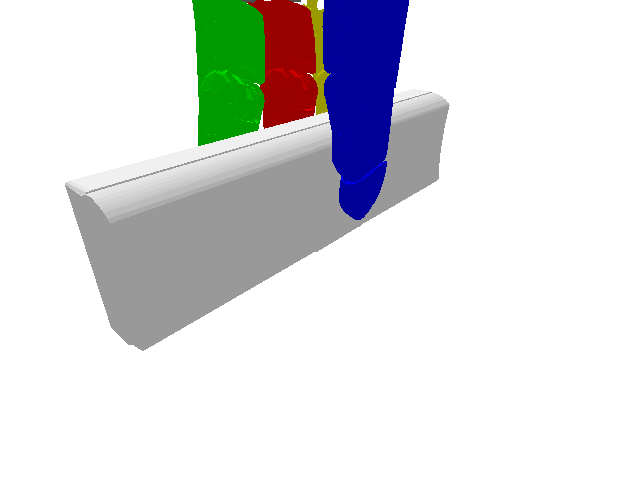

Grasp 7: score = 11.767
    palm  (xyz, qxqyqzqw) = [0.003, 0.047, 0.286, 0.992, 0.042, -0.078, 0.089]
    joints (12 angles)  = [-0.069, 0.631, -0.154, -0.288, 0.711, -0.167, -0.308, 0.681, -0.158, -0.19, 0.591, -0.102]


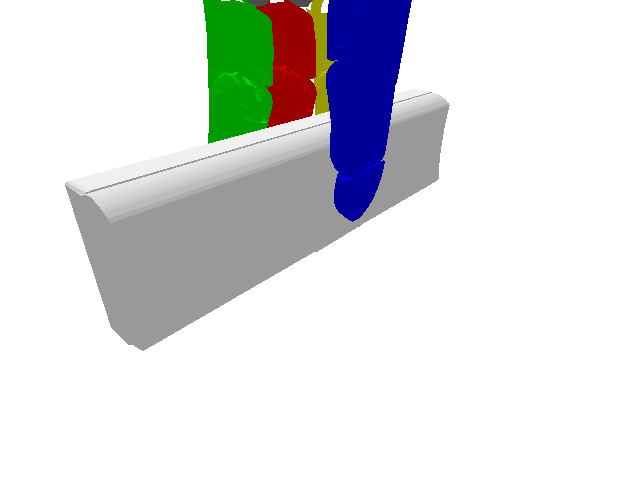

Grasp 8: score = 11.115
    palm  (xyz, qxqyqzqw) = [0.011, 0.084, 0.281, 0.977, 0.034, -0.114, 0.179]
    joints (12 angles)  = [0.018, 0.681, -0.131, -0.12, 0.791, -0.173, -0.363, 0.741, -0.173, -0.253, 0.541, -0.108]


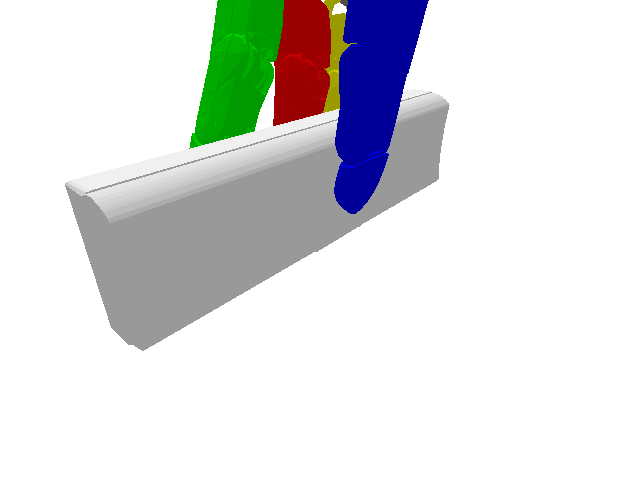

Grasp 9: score = 14.133
    palm  (xyz, qxqyqzqw) = [0.034, 0.018, 0.268, 0.977, 0.076, -0.191, 0.047]
    joints (12 angles)  = [-0.022, 0.841, -0.141, -0.064, 0.921, -0.162, -0.361, 0.841, -0.143, -0.366, 0.431, -0.151]


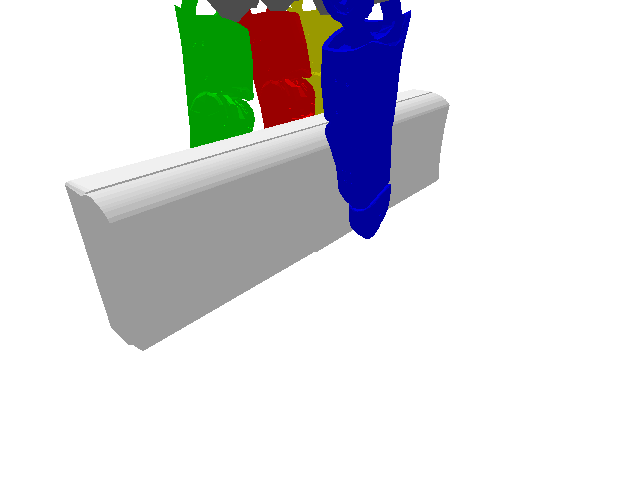

In [5]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Point to your data folder ──
# not in the split_50
root      = Path("../data/studentGrasping/student_grasps_v1/03211117/2f12da0c7460b22cd3ab2bc0f53ca878/3")

# not in the split_25
# root  = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
# root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f    = root / "mesh.obj"
recording = root / "recording.npz"
assert mesh_f.exists(),    f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load the hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load the object mesh once ──
v = p.createVisualShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
c = p.createCollisionShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
p.createMultiBody(baseVisualShapeIndex=v, baseCollisionShapeIndex=c,
                  basePosition=[0,0,0], baseOrientation=[0,0,0,1],
                  physicsClientId=cid)

# ── 5) Load recorded grasps & scores ──
data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

n        = min(10, grasps.shape[0])  # show up to first 10
poses7d  = grasps[:n, :7]            # palm pose
angles12 = grasps[:n, 7:19]          # joint angles
scores_n = scores[:n]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop with score printout ──
for i, (pose7d, angles, score) in enumerate(zip(poses7d, angles12, scores_n)):
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    # reset all 12 finger joints (and their coupled partners)
    for a, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # grab a quick camera frame
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.3,
        yaw=45, pitch=-30, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    _, _, rgba, _, _ = p.getCameraImage(
        640, 480,
        viewMatrix=view, projectionMatrix=proj,
        physicsClientId=cid
    )
    img = Image.fromarray(rgba[:, :, :3])

    # print score, palm pose, and joint angles
    print(f"Grasp {i}: score = {score:.3f}")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)

    time.sleep(0.5)  # pause so you can visually inspect each grasp

p.disconnect(physicsClientId=cid)


In [15]:
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",            # your trained regressor
    config_path="../configs/train_joint.yaml",
    #backbone_ckpt="checkpoints/pretrain_pointjepa.ckpt",  # if you want to override backbone first
    device="cuda:0",
)

angles = predict_joint_angles(
    model,
    mesh_path="../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj",
    pose7d=[0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0],
)
print("Predicted joint angles:", angles)


Predicted joint angles: [-0.149     0.1322   -0.2136    0.09985  -0.1733   -0.04956   0.03072
 -0.09595   0.008736  0.028    -0.10754  -0.02014 ]


## PyBullet Script

In [16]:
"""
grasp_vis.py
============

Tiny utility to render a single grasp with the DLR-II hand in PyBullet.

Usage from a script / notebook
------------------------------
model = load_model(...)

pose7d  = [0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0]          # xyz + quaternion
mesh    = "../data/grasp_sample/02818832/.../mesh.obj"

predict_and_visualize(model, mesh, pose7d, hand_urdf="urdfs/dlr2.urdf")
"""

from pathlib import Path
import numpy as np
import pybullet as p
import pybullet_data
import argparse
from typing import Sequence

# order expected by the DLR-II URDF (same as the supervisor’s script)
_HAND_JOINT_INDICES = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21]
_COUPLED_JOINTS     = {3, 9, 15, 21}        # They also drive j+1

def _ensure_connection(gui: bool = True) -> int:
    """Connect to PyBullet once and return the client id."""
    if p.isConnected():
        return p.getConnectionInfo()['clientIndex']
    connection_mode = p.GUI if gui else p.DIRECT
    return p.connect(connection_mode)


def visualize_grasp(
        mesh_path: str | Path,
        pose7d: Sequence[float],
        joint_angles: Sequence[float],
        *,
        hand_urdf: str = "urdfs/dlr2.urdf",
        object_mass: float = 1.0,
        mesh_scale: float | Sequence[float] = 1.0,
        wait_for_input: bool = True,
) -> None:
    """
    Show a single grasp in PyBullet.

    Parameters
    ----------
    mesh_path        : path to the object mesh (.obj)
    pose7d           : (x, y, z, qx, qy, qz, qw) world-space hand base pose
    joint_angles     : iterable of 12 angles in radians (DLR-II finger order)
    hand_urdf        : path to hand URDF
    object_mass      : mass (kg) given to the visual/collision mesh
    mesh_scale       : uniform or xyz scale factor for the mesh
    wait_for_input   : if True, waits for <Enter> before exiting
    """
    if len(pose7d) != 7:
        raise ValueError("pose7d must have 7 elements (xyz + quaternion)")
    if len(joint_angles) != 12:
        raise ValueError("joint_angles must have 12 elements")

    _ensure_connection(gui=True)
    p.resetSimulation()                              # fresh scene
    p.setAdditionalSearchPath(pybullet_data.getDataPath())

    # ------------------------------------------------------------------ hand
    hand_id = p.loadURDF(
        hand_urdf,
        globalScaling=1,
        basePosition=pose7d[:3],
        baseOrientation=pose7d[3:],
        useFixedBase=True,
        flags=p.URDF_MAINTAIN_LINK_ORDER,
    )

    # ----------------------------------------------------------------- object
    mesh_path = Path(mesh_path)
    vshape = p.createVisualShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
        rgbaColor=[1, 1, 1, 1],
        specularColor=[.4, .4, .4],
        visualFramePosition=[0, 0, 0],
    )
    cshape = p.createCollisionShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
    )
    obj_id = p.createMultiBody(
        baseMass=object_mass,
        baseVisualShapeIndex=vshape,
        baseCollisionShapeIndex=cshape,
        basePosition=[0, 0, 0],
        baseOrientation=[0, 0, 0, 1],
    )

    # ---------------------------------------------------------- joint angles
    for angle, j in zip(joint_angles, _HAND_JOINT_INDICES):
        p.resetJointState(hand_id, jointIndex=j, targetValue=angle)
        if j in _COUPLED_JOINTS:                     # drive the coupled joint
            p.resetJointState(hand_id, jointIndex=j + 1, targetValue=angle)

    p.stepSimulation()

    if wait_for_input:
        print("Press <Enter> in the console to close the preview …")
        try:
            input()
        except (EOFError, KeyboardInterrupt):
            pass
    p.disconnect()

pybullet build time: Jan 29 2025 23:16:28


In [19]:
import numpy as np
from pathlib import Path

root     = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record   = root / "recording.npz"
mesh_obj = root / "mesh.obj"

# Correctly load the .npz
data    = np.load(record, allow_pickle=False)   # recording.npz is pure numpy arrays
grasps  = data["grasps"]                        # shape: (24,19)
scores  = data["scores"]                        # shape: (24,)

# Extract the first 7 cols (pose7d) of your first 3 grasps
pose7ds = grasps[:3, :7]                        # (3,7)
print("Loaded poses:", pose7ds.shape, "mesh path:", mesh_obj)

Loaded poses: (3, 7) mesh path: ../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj


In [ ]:

# (re)load your model if you haven’t already
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

for i, pose7d in enumerate(pose7ds):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    print(f"Grasp #{i}: pose={pose7d}, predicted angles={angles}")
    visualize_grasp(
        mesh_path=mesh_obj,
        pose7d=pose7d,
        joint_angles=angles,
        hand_urdf="urdfs/dlr2.urdf",
        wait_for_input=False,   # in notebooks you often don’t want to block
    )


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# ── your predictor/model imports ──
# ───────────────────────────────────

# constants for the DLR-II hand (same as before)
JOINT_INDICES  = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3, 9, 15, 21}

# 1) connect and load once
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# 2) load hand URDF (fixed base)
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    globalScaling=1,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# 3) load object mesh once
root     = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_obj = str(root / "mesh.obj")
vshape = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
    rgbaColor=[1,1,1,1],
)
cshape = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
)
obj_id = p.createMultiBody(
    baseMass=1,
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# 4) load your model
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

# 5) grab the first 3 poses
data    = np.load(root / "recording.npz")
poses7d = data["grasps"][:3, :7]   # shape (3,7)

# 6) loop and just RESET, no reload
for i, pose7d in enumerate(poses7d):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:])
    # reset the 12 finger joints
    for angle, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, angle)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, angle)
    
    p.stepSimulation()
    print(f"Showing grasp #{i} — press Ctrl+C in console or close window to stop")
    time.sleep(1.0)    # display each grasp for one second

# when done, disconnect
p.disconnect()


In [6]:
import time
import numpy as np
from pathlib import Path

root    = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record  = np.load(root / "recording.npz")
poses7d = record["grasps"][:3, :7]

model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()                                                  # ensure eval mode

infer_times = []
for pose in poses7d:
    t0 = time.time()
    with torch.no_grad():                                     # avoid autograd
        angles = predict_joint_angles(model,
                                       mesh_path=str(root/"mesh.obj"),
                                       pose7d=pose)
    infer_times.append(time.time() - t0)
print("Per-grasp inference times:", [f"{t:.3f}s" for t in infer_times])


Per-grasp inference times: ['0.788s', '0.024s', '0.023s']


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# hand joint indices
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED      = {3,9,15,21}

# ── Connect & scene setup ──
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# load the hand once
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# load the object mesh once
root   = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_f = str(root / "mesh.obj")
vshape = p.createVisualShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
cshape = p.createCollisionShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
p.createMultiBody(
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# load model once
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

# load poses
data    = np.load(root / "recording.npz", allow_pickle=False)
poses7d = data["grasps"][:3, :7]   # pick first 3
print("Setup done—ready to roll.")


In [ ]:
import pybullet as p
import pybullet_data
from pathlib import Path

# 1) Connect and verify
cid = p.connect(p.GUI)
print("Physics client ID:", cid)
print("Is connected?", p.isConnected(cid))
if cid < 0 or not p.isConnected(cid):
    raise RuntimeError("Failed to open PyBullet GUI")

# 2) Add search paths
#    - the built-in pybullet_data (ground plane, etc.)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#    - plus your project root so that "urdfs/dlr2.urdf" can be found
project_root = Path.cwd()  # or wherever your repo root is
p.setAdditionalSearchPath(str(project_root))

# 3) Reset simulation on that client
p.resetSimulation(physicsClientId=cid)

# 4) Try loading your URDF, explicitly on that client
hand_urdf = str(project_root / "urdfs" / "dlr2.urdf")
hand_id = p.loadURDF(
    hand_urdf,
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)
print("Loaded hand body ID:", hand_id)


## Helper: Checkpoint Inspector

In [11]:
def inspect_checkpoint(
    ckpt_path: str,
    prefix_filter: str | None = None
) -> None:
    """
    Print all parameter keys saved in a checkpoint. Optionally filter by prefix.

    Args:
        ckpt_path: path to the .ckpt or .pth file
        prefix_filter: only show keys containing this substring
    """
    # Load checkpoint on CPU
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state = ckpt.get('state_dict', ckpt)
    keys = list(state.keys())

    if prefix_filter:
        keys = [k for k in keys if prefix_filter in k]

    print(f"Found {len(keys)} parameters{' with filter ' + prefix_filter if prefix_filter else ''}:")
    for k in sorted(keys):
        print(k)

In [12]:
inspect_checkpoint("../configs/checkpoints/jepa_no_FT.ckpt")


Found 546 parameters:
mask_token
positional_encoding.0.bias
positional_encoding.0.weight
positional_encoding.2.bias
positional_encoding.2.weight
predictor.mask_token
predictor.positional_encoding.0.bias
predictor.positional_encoding.0.weight
predictor.positional_encoding.2.bias
predictor.positional_encoding.2.weight
predictor.predictor.blocks.0.attn.proj.bias
predictor.predictor.blocks.0.attn.proj.weight
predictor.predictor.blocks.0.attn.qkv.bias
predictor.predictor.blocks.0.attn.qkv.weight
predictor.predictor.blocks.0.mlp.fc1.bias
predictor.predictor.blocks.0.mlp.fc1.weight
predictor.predictor.blocks.0.mlp.fc2.bias
predictor.predictor.blocks.0.mlp.fc2.weight
predictor.predictor.blocks.0.norm1.bias
predictor.predictor.blocks.0.norm1.weight
predictor.predictor.blocks.0.norm2.bias
predictor.predictor.blocks.0.norm2.weight
predictor.predictor.blocks.1.attn.proj.bias
predictor.predictor.blocks.1.attn.proj.weight
predictor.predictor.blocks.1.attn.qkv.bias
predictor.predictor.blocks.1.attn.q